In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def get_error(X, recon):
    return ((X-recon)**2).sum()/X.shape[0]

def get_recon(X, d):
    u, s, v = np.linalg.svd(X, full_matrices=False)
    recon = u[:, :d] @ np.diag(s[:d]) @ v[:d, :]
    
    return recon, v

def buggy_pca(X, d):
    recon, v = get_recon(X, d)
    error = get_error(X, recon)
    
    return recon, v, error

def demeaned_pca(X, d):
    dX = X - X.mean(axis=0)
    recon, v = get_recon(dX, d)
    recon += X.mean(axis=0)
    error = get_error(X, recon)
    return recon, v, error

def normalized_pca(X, d):
    
    nX = (X - X.mean(axis=0)) / X.std(axis=0)
    recon, v = get_recon(nX, d)
    recon = (recon * X.std(axis=0)) + X.mean(axis=0)
    error = get_error(X, recon)
    return recon, v, error 


def DRO(X, d):
    b = X.mean(axis=0)
    recon, v = get_recon(X-b, d)
    ZA = recon

    DRO = ZA + b
    error = get_error(X, DRO)
    
    return DRO, None, error



def plot_pca(df, recon, name):
    plt.figure(figsize=(5, 5))

    plt.scatter(df[:, 0] , df[:, 1])
    plt.scatter(recon[:, 0],  recon[:, 1], marker='x')
    
    plt.title(name)
    plt.ylim(0, 10)
    plt.xlim(0, 10)
    plt.savefig('images/pca_{}.jpg'.format(name.replace(' ', '_')))
    plt.show();

In [3]:
df = np.loadtxt('data/data2D.csv', delimiter=',')

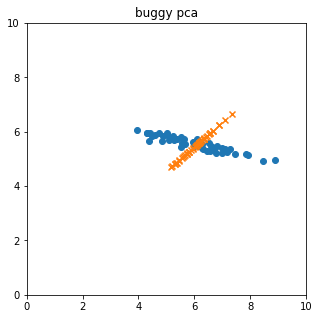

error: 0.8869030837347941


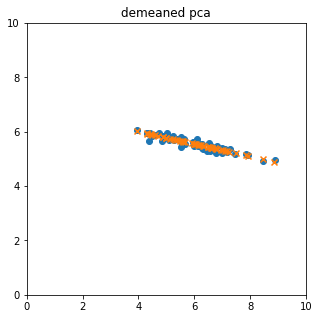

error: 0.010006085628512917


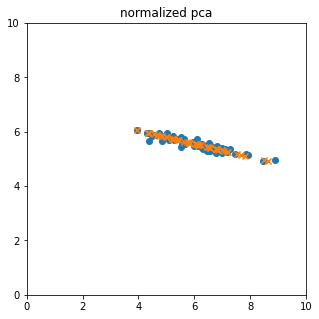

error: 0.04947208345477068


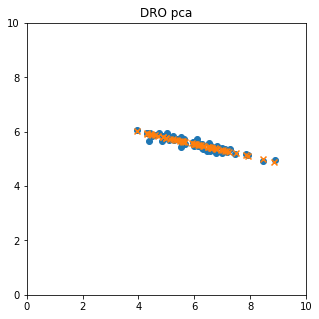

error: 0.010006085628512917


In [4]:
recon, y, error = buggy_pca(df, 1)

plot_pca(df, recon, name='buggy pca')
print('error:', error)

recon, y, error = demeaned_pca(df, 1)

plot_pca(df, recon, name='demeaned pca')
print('error:', error)


recon, y, error = normalized_pca(df, 1)

plot_pca(df, recon, name='normalized pca')
print('error:', error)


recon, y, error = DRO(df, 1)
plot_pca(df, recon, name='DRO pca')
print('error:', error)

In [5]:
from tqdm.notebook import tqdm

In [6]:
df = np.loadtxt('data/data1000D.csv', delimiter=',')

In [7]:
def plot_errors(errors, name, knee=29):
    plt.plot(errors)
    plt.axvline(x = knee, color = 'grey', label = 'knee point={}'.format(knee))
    plt.legend()
    plt.title(name)
    plt.savefig('images/pca_elbow_errors.jpg')
    plt.show()

  0%|          | 0/99 [00:00<?, ?it/s]

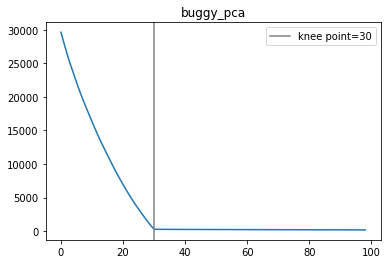

272.7699492218145


In [8]:
errors = []
# for i in tqdm(range(df.shape[1]-10, 900, -10)):
for i in tqdm(range(1, 100)):
    recon, y, error = buggy_pca(df, i)
    errors.append(error)

plot_errors(errors, 'buggy_pca', knee=30)
print(errors[30])

In [9]:
recon, y, error = buggy_pca(df, 498)
print(error)
recon, y, error = buggy_pca(df, 499)
print(error)

0.11702118066329123
0.0566116859366162


  0%|          | 0/100 [00:00<?, ?it/s]

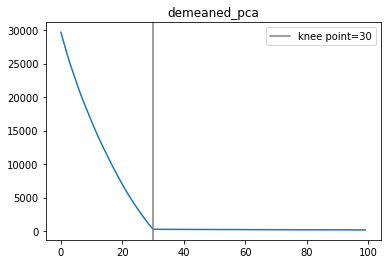

273.04595897860275


In [10]:
errors = []
# for i in tqdm(range(df.shape[1]-10, 900, -10)):
for i in tqdm(range(100)):
    recon, y, error = demeaned_pca(df, i)
    errors.append(error)
plot_errors(errors, 'demeaned_pca', knee=30)
print(errors[30])

In [11]:
recon, y, error = demeaned_pca(df, 498)
print(error)
recon, y, error = demeaned_pca(df, 499)
print(error)

0.05670115554882725
3.544551183624983e-25


  0%|          | 0/100 [00:00<?, ?it/s]

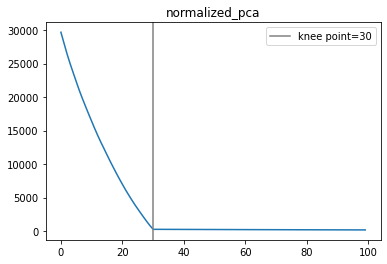

273.6285809976232


In [12]:
errors = []
# for i in tqdm(range(df.shape[1]-10, 900, -10)):
for i in tqdm(range(100)):
    recon, y, error = normalized_pca(df, i)
    errors.append(error)
plot_errors(errors, 'normalized_pca', knee=30)
print(errors[30])

In [13]:
recon, y, error = normalized_pca(df, 498)
print(error)
recon, y, error = normalized_pca(df, 499)
print(error)

0.059181611557504336
5.617515760315664e-25


  0%|          | 0/100 [00:00<?, ?it/s]

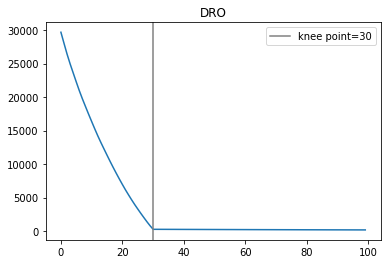

273.04595897860275


In [14]:
errors = []
# for i in tqdm(range(df.shape[1]-10, 900, -10)):
for i in tqdm(range(0, 100)):
    recon, y, error = DRO(df, i)
    errors.append(error)
    
plot_errors(errors, 'DRO', knee=30)
print(errors[30])

In [15]:
recon, y, error = DRO(df, 498)
print(error)
recon, y, error = DRO(df, 499)
print(error)

0.05670115554882725
3.544551183624983e-25


In [16]:
# bigerrors = []
# for i in tqdm(range(1, 1000)):
#     recon, y, error = normalized_pca(df, i)
#     bigerrors.append(error)
# plt.plot(bigerrors)

In [17]:
# This part of the code was taken from: https://github.com/ymcdull/ppca/blob/master/ppca.py
import numpy as np
from scipy import special
from numpy.random import randn
from numpy.matlib import repmat

## updating W, X and tau when doing inference
class PPCA:
    ## Y: input continuous data with shape (N, M)
    ## D: number of ppca components
    def __init__(self, D = 2, n_iters = 100):
        self.D = D
        self.n_iters = n_iters
        
    def _init_paras(self, N, M, D):
        self.a = 1.0
        self.b = 1.0
        self.e_tau = self.a / self.b
        self.e_w = randn(M, D)
        self.e_wwt = np.zeros((D, D, M))
        for m in range(M):
            ## use np.newaxis here to transfer numpy array from 1D to 2D
            self.e_wwt[:, :, m] = np.eye(D) + self.e_w[m, :][np.newaxis].T.dot(self.e_w[m, :][np.newaxis])

        self.e_X = np.zeros((N, D))
        self.e_XXt = np.zeros((D, D, N))

    def _update_X(self, Y, N, D):
        self.sigx = np.linalg.inv(np.eye(D) + self.e_tau * np.sum(self.e_wwt, axis = 2))
        for n in range(N):
            self.e_X[n, :] = self.e_tau * self.sigx.dot(np.sum(self.e_w * np.tile(Y[n, :], (D, 1)).T, axis = 0))
            self.e_XXt[:, :, n] = self.sigx + self.e_X[n, :][np.newaxis].T.dot(self.e_X[n, :][np.newaxis])

    def _update_W(self, Y, M, D):
        self.sigw = np.linalg.inv(np.eye(D) + self.e_tau * np.sum(self.e_XXt, axis = 2))
        for m in range(M):
            self.e_w[m, :] = self.e_tau * self.sigw.dot(np.sum(self.e_X * np.tile(Y[:, m], (D, 1)).T, axis = 0))
            self.e_wwt[:, :, m] = self.sigw + self.e_w[m, :][np.newaxis].T.dot(self.e_w[m, :][np.newaxis])

    def _update_tau(self, Y, M, N):
        self.e = self.a + N * M * 1.0 / 2
        outer_expect = 0
        for n in range(N):
            for m in range(M):
                outer_expect = outer_expect \
                                + np.trace(self.e_wwt[:, :, m].dot(self.sigx)) \
                                + self.e_X[n, :][np.newaxis].dot(self.e_wwt[:, :, m]).dot(self.e_X[n, :][np.newaxis].T)[0][0]
        self.f = self.b + 0.5 * np.sum(Y ** 2) - np.sum(Y * self.e_w.dot(self.e_X.T).T) + 0.5 * outer_expect
        self.e_tau = self.e / self.f
        self.e_log_tau = np.mean(np.log(np.random.gamma(self.e, 1/self.f, size=1000)))
    
   
    def _update(self, Y, N, M, D):
        self._update_X(Y, N, D)
        self._update_W(Y, M, D)
        self._update_tau(Y, M, N)
       
        
    def fit(self, Y):
        N, M = Y.shape
        D = self.D
        self._init_paras(N, M, D)

        for it in range(self.n_iters):
            self._update(Y, N, M, D)

    def recover(self):
        return self.e_X.dot(self.e_w.T)

In [18]:
def DRVL(X, d):
    dX = X - X.mean(axis=0)
    pca = PPCA(D = d, n_iters=1000)
    pca.fit(dX-dX.mean(axis=0))
    recon = pca.recover()
    error = get_error(dX, recon)
    recon = recon + X.mean(axis=0)
    return recon, None, error

In [ ]:
recon, y, error = DRVL(df, 1)

In [ ]:
plot_pca(df, recon, name='DRVL pca')
print('error:', error)

In [ ]:
recon, y, error = DRVL(df, 30)
print(error)